In [1]:
import logging

import pickle

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns
from pyro import poutine
from sklearn import metrics

In [2]:
pyro.set_rng_seed(10)

In [3]:

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)
print(data.shape)

nan_mask = np.isnan(data) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )

(1127, 5237)
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [4]:
class PMF_zero_inflated_poisson(nn.Module):

    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self,data, train, dim):
        super().__init__()
        """Build the Probabilistic Matrix Factorization model using pymc3.



        """
        self.dim = dim   
        self.data = data.copy()
        self.n, self.m = self.data.shape
        self.map = None
        self.bounds = (0,1)
        self.losses = None
        self.predictions = None
        self.returned = None
        self.predictive_svi = None


        # Perform mean value imputation
    
        
        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = (np.mean(self.data, axis=1).mean())**2 / np.std(self.data, axis=1).mean()
        self.alpha_v = (np.mean(self.data, axis=0).mean())**2 / np.std(self.data, axis=0).mean()
        
        self.beta_u = (np.mean(self.data, axis=1).mean()) / np.std(self.data, axis=1).mean()
        self.beta_v = (np.mean(self.data, axis=0).mean()) / np.std(self.data, axis=0).mean()
        self.bias = self.data.mean()
        self.alpha = 1


    def model(self, train, mask):
        alpha = 1
        beta = 1

        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(self.alpha_u, self.beta_u).expand([self.dim]).to_event(1))
            #alpha = pyro.sample("alpha", dist.Poisson(self.alpha))
            p = pyro.sample("p", dist.Beta(alpha, beta))
        
        with sideeffect_plate:
            VA = pyro.sample("VA", dist.Gamma(self.alpha_v, self.beta_v).expand([self.dim]).to_event(1))
            #possibly add intercepts VA_int = pyro.sample("VA", dist.Normal(0., 1.).to_event(1))
       
        u2_plate = pyro.plate("u2_plate", self.n, dim=-2)

        with sideeffect_plate, u2_plate: 
           # with pyro.poutine.mask(mask=mask):
             Y = pyro.sample("target", dist.ZeroInflatedPoisson( rate = UA@VA.T ,gate = p[:, np.newaxis]), obs=train ) 
             return Y
        

    def guide(self, train=None, mask=None):

        d_alpha = pyro.param('d_alpha', torch.ones(self.n,self.dim), constraint=constraints.positive)#*self.user_mean)
        d_beta = pyro.param('d_beta', 0.5*torch.ones(self.n,self.dim), constraint=constraints.positive)
        rate_alpha = pyro.param('rate_alpha', torch.ones(self.n), constraint=constraints.positive)
        rate_beta = pyro.param('rate_beta', torch.ones(self.n), constraint=constraints.positive)


        s_alpha = pyro.param('s_alpha', torch.ones(self.m,self.dim), constraint=constraints.positive)#*self.item_mean)
        s_beta = pyro.param('s_beta', 0.5*torch.ones(self.m,self.dim), constraint=constraints.positive)
        drug_plate = pyro.plate("drug_latents", self.n, dim= -1) #independent users
        sideeffect_plate = pyro.plate("sideeffect_latents", self.m, dim= -1) #independent items

        with drug_plate: 
            UA = pyro.sample("UA", dist.Gamma(d_alpha, d_beta).to_event(1))
            p = pyro.sample("p", dist.Beta(rate_beta,rate_alpha))

        with sideeffect_plate: 
            VA = pyro.sample("VA", dist.Gamma(s_alpha, s_beta).to_event(1))
    
    def train_SVI(self,train,mask, nsteps=250, lr = 0.05, lrd = 1, verbose=True):
        logging.basicConfig(format='%(message)s', level=logging.INFO)
        svi = SVI(self.model,
        self.guide,
        optim.ClippedAdam({"lr": lr, "lrd": lrd}),
        loss=Trace_ELBO())
        losses = []
        for step in range(nsteps):
            elbo = svi.step(torch.from_numpy(train).float(), mask)
            losses.append(elbo)
            if(verbose):
                if step % 10 == 0:
                    print("Elbo loss: {}".format(elbo))
        self.losses = losses
        #constrained_params = list(pyro.get_param_store().values())
        #PARAMS = [p.unconstrained() for p in constrained_params]
        #print(PARAMS)
        return losses
    
    def sample_predict(self, nsamples=500 , verbose=True):
        unmasked =torch.ones((self.n,self.m), dtype=torch.bool)
        predictive_svi = Predictive(self.model, guide=self.guide, num_samples=nsamples)(None , unmasked)
        if (verbose):
            for k, v in predictive_svi.items():
                print(f"{k}: {tuple(v.shape)}")
        table = predictive_svi["target"].numpy()
        self.predictive_svi = predictive_svi
        print(table)
        self.returned = table
        mc_table = table.mean(axis = 0)
        mc_table_std = table.std(axis = 0)
        mc_table[mc_table < self.bounds[1]] = self.bounds[0]
        mc_table[mc_table >= self.bounds[1]] = self.bounds[1]
        self.predictions = mc_table
        
    def predictive_score(self,test,masked):
        # total = test.shape[0]*test.shape[1]
        
        UA =  self.predictive_svi["UA"]
        VA = self.predictive_svi["VA"]
        p=self.predictive_svi["p"].mean(axis=0).reshape(self.n)
        VA = VA.mean(axis=0).reshape(self.m,self.dim)
        UA = UA.mean(axis=0).reshape(self.n,self.dim)
        print(UA.shape)
        score =  dist.ZeroInflatedPoisson( rate = UA@VA.T ,gate = p[:, np.newaxis]).log_prob(torch.from_numpy(test))
        mean_score = (score*masked).reshape(-1).logsumexp(-1) -np.log(test.shape[0]*test.shape[1])
        return mean_score
        
    
    def rmse(self,test):
        low, high = self.bounds
        test_data = test.copy()
        test_data[test_data < high] = low
        test_data[test_data >= high] = high
        sqerror = abs(test_data - self.predictions) ** 2  # squared error array
        mse = sqerror.sum()/(test_data.shape[0]*test_data.shape[1])
        print("PMF MAP training RMSE: %.5f" % np.sqrt(mse))
        fpr, tpr, thresholds = metrics.roc_curve(test_data.astype(int).flatten(),  self.predictions.astype(int).flatten(), pos_label=1)
        metrics.auc(fpr, tpr)
        print("AUC: %.5f" % metrics.auc(fpr, tpr))
        return np.sqrt(mse) , metrics.auc(fpr, tpr)

    def get_predictions(self):
        return (self.returned,self.predictions)

    

In [5]:
with open('data_train.pickle', 'rb') as handle:
    data2 = pickle.load(handle)
print(data2.shape)

with open('data_all.pickle', 'rb') as handle:
    data = pickle.load(handle)

def predictive_score_for_diim_estimation(data_all, train, classname):
    score=[]
    for d in [1,5,10,20,50,75,100,200,250]:
        nan_mask = np.isnan(train) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
        test = classname(data_all,train, d)  
        pyro.clear_param_store()
        test.train_SVI(data_all , ~torch.from_numpy(nan_mask), verbose = False)
        test.sample_predict(500)
        score.append(test.predictive_score(data_all,  ~torch.from_numpy(nan_mask)))
    return score

s = predictive_score_for_diim_estimation(data,data2, PMF_zero_inflated_poisson)

(1127, 5237)
UA: (500, 1, 1127, 1)
p: (500, 1, 1127)
VA: (500, 1, 5237, 1)
target: (500, 1127, 5237)
[[[  4.   1.   0. ...   3.   4.   3.]
  [  5.   0.   0. ...   0.   3.   1.]
  [ 15.   0.   0. ...   2.  18.   0.]
  ...
  [  7.   0.   0. ...   2.   0.   0.]
  [ 32.   3.   0. ...   0.  49.   2.]
  [  0.   0.   0. ...   0.  25.   0.]]

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   3.   0. ...   0.   0.   0.]
  [  6.   0.   0. ...  12.   8.  29.]
  ...
  [  5.   2.   1. ...  10.   0.   0.]
  [ 15.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  1.   0.   0. ...   0.   0.   1.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  ...
  [ 18.   0.   0. ...   3.  19.  12.]
  [  0.   0.   0. ...   0.   0.   4.]
  [  0.   0.   0. ...   0.   0.   0.]]

 ...

 [[  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  5.   0.   0. ...   0.   0.   8.]
  ...
  [  0.   0.   3. ...   9.  32.   0.]
  [  0.   0.   0. ...   0. 

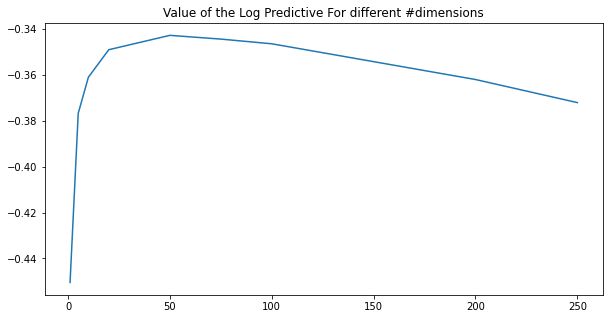

In [6]:
d = [1,5,10,20,50,75,100,200,250]
plt.figure(figsize=(10, 5))
plt.plot(d, s)
plt.title("Value of the Log Predictive For different #dimensions")
plt.savefig("predictive_score_zip.png")
plt.show()
pyro.clear_param_store()

In [7]:

nan_mask = np.isnan(data) #when calculating the train/test set to "nan" all the examples that are for testing so that you do not train on them 
print(torch.from_numpy(nan_mask) )
test = PMF_zero_inflated_poisson(train=data, dim=100)
test.train_SVI(data, ~torch.from_numpy(nan_mask))



tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])
Elbo loss: 13729418.012771606
Elbo loss: 13750145.610977173
Elbo loss: 13962415.76576233
Elbo loss: 14119793.30834961
Elbo loss: 13824654.43333435
Elbo loss: 13529111.021270752
Elbo loss: 13652855.801116943
Elbo loss: 13721328.9821167
Elbo loss: 13713437.802825928
Elbo loss: 13583459.632843018
Elbo loss: 13578454.516143799
Elbo loss: 13874178.841888428
Elbo loss: 13529643.261825562
Elbo loss: 13496243.551498413
Elbo loss: 13694373.06930542
Elbo loss: 14108100.281860352
Elbo loss: 13625978.810073853
Elbo loss: 13809180.250991821
Elbo loss: 13647418.549407959
Elbo loss: 13414881.601287842
Elbo loss: 13374836.144683838
Elbo loss: 136

[13729418.012771606,
 13799094.6040802,
 13937064.166641235,
 14044982.368469238,
 13740619.588027954,
 14102335.373184204,
 14144757.285995483,
 14303679.13168335,
 13957817.211029053,
 14330843.800842285,
 13750145.610977173,
 14096368.707519531,
 13901555.47517395,
 14066655.321548462,
 14226695.234725952,
 13725984.370407104,
 14066136.482330322,
 13839212.206588745,
 13854251.875823975,
 13762393.408065796,
 13962415.76576233,
 14064696.379089355,
 13823601.69203186,
 13776417.682678223,
 13716088.710235596,
 13696205.110061646,
 13693988.414520264,
 13681650.319534302,
 13648156.417098999,
 13508108.145874023,
 14119793.30834961,
 13991413.649398804,
 13794762.69897461,
 13966015.728988647,
 13651513.499816895,
 14044038.64138794,
 13633606.217758179,
 13745714.428619385,
 14126495.49293518,
 14070257.738983154,
 13824654.43333435,
 13906832.114593506,
 13913919.809814453,
 13824604.572677612,
 14103393.58883667,
 13857544.905853271,
 13991888.443603516,
 13700721.345794678,
 137

In [8]:
test.sample_predict(1000)



UA: (1000, 1, 1127, 100)
p: (1000, 1, 1127)
VA: (1000, 1, 5237, 100)
target: (1000, 1127, 5237)
[[[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  2.  0. ...  0.  0.  0.]
  [ 2.  1.  0. ...  0.  0.  0.]
  ...
  [ 0.  2.  1. ...  0.  0.  1.]
  [ 5.  0.  0. ...  0. 30.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  1.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 1.  0.  0. ...  0.  0.  0.]
  ...
  [16.  1.  0. ... 13. 17.  0.]
  [ 2.  0.  0. ...  4. 20.  3.]
  [ 0.  1.  0. ...  3.  1.  1.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 1.  0.  0. ...  4.  0.  0.]
  ...
  [ 0.  0.  0. ...  6.  0.  0.]
  [ 3.  0.  1. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[ 3.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 2.  0.  0. ...  0.  7.  1.]
  ...
  [12.  1.  2. ...  2.  0.  1.]
  [ 3.  1.  0. ...  9. 29.  1.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  1.]
  

In [9]:
test.rmse(data)
print(test.get_predictions())
print(data)


PMF MAP training RMSE: 0.36273
AUC: 0.81252
(array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  2.,  0., ...,  0.,  0.,  0.],
        [ 2.,  1.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  2.,  1., ...,  0.,  0.,  1.],
        [ 5.,  0.,  0., ...,  0., 30.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [16.,  1.,  0., ..., 13., 17.,  0.],
        [ 2.,  0.,  0., ...,  4., 20.,  3.],
        [ 0.,  1.,  0., ...,  3.,  1.,  1.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  4.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  6.,  0.,  0.],
        [ 3.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 3.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.